# 0.0. IMPORTS

In [1]:
import math
import json
import random
import pickle
import datetime
import warnings
import inflection
import numpy    as np
import pandas   as pd
import xgboost  as xgb
import seaborn  as sns


from scipy                  import stats    as ss
from boruta                 import BorutaPy
from matplotlib             import pyplot   as plt
from IPython.display        import Image
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from IPython.core.display   import HTML
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_percentage_error(y, yhat):
    return np.mean(  (y-yhat)/y ) 

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y-yhat)/y) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse}, index=[0]
        )

def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/n-1 )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)


    return np.sqrt( ( chi2corr/n ) / ( min(kcorr-1,rcorr-1) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2. Settigns

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/flpj08/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.3. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


cols_new = list(map(lambda x: inflection.underscore(x), cols_old))

# Renaming columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Type

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance
df1['competition_distance'].fillna(200000.0, inplace= True)

#competition_open_since_month
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if np.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if np.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if np.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if np.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace= True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [12]:
#competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
#competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
#promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct_mean     = pd.DataFrame( num_attributes.apply(lambda x: np.mean(x)) ).T
ct_median   = pd.DataFrame( num_attributes.apply(lambda x: np.median(x)) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d_std       = pd.DataFrame( num_attributes.apply(lambda x: np.std(x)) ).T
d_min       = pd.DataFrame( num_attributes.apply(lambda x: np.min(x)) ).T
d_max       = pd.DataFrame( num_attributes.apply(lambda x: np.max(x)) ).T
d_range     = pd.DataFrame( num_attributes.apply(lambda x: ( np.max(x)-np.min(x) )) ).T
d_skew      = pd.DataFrame( num_attributes.apply(lambda x: x.skew() )).T
d_kurtosis  = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis()) ).T

# concatenate
m = pd.concat([d_min, d_max, d_range, ct_mean, ct_median, d_std, d_skew, d_kurtosis]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [17]:
# Verificação de quantos níveis cada variável categórica possui.
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [18]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

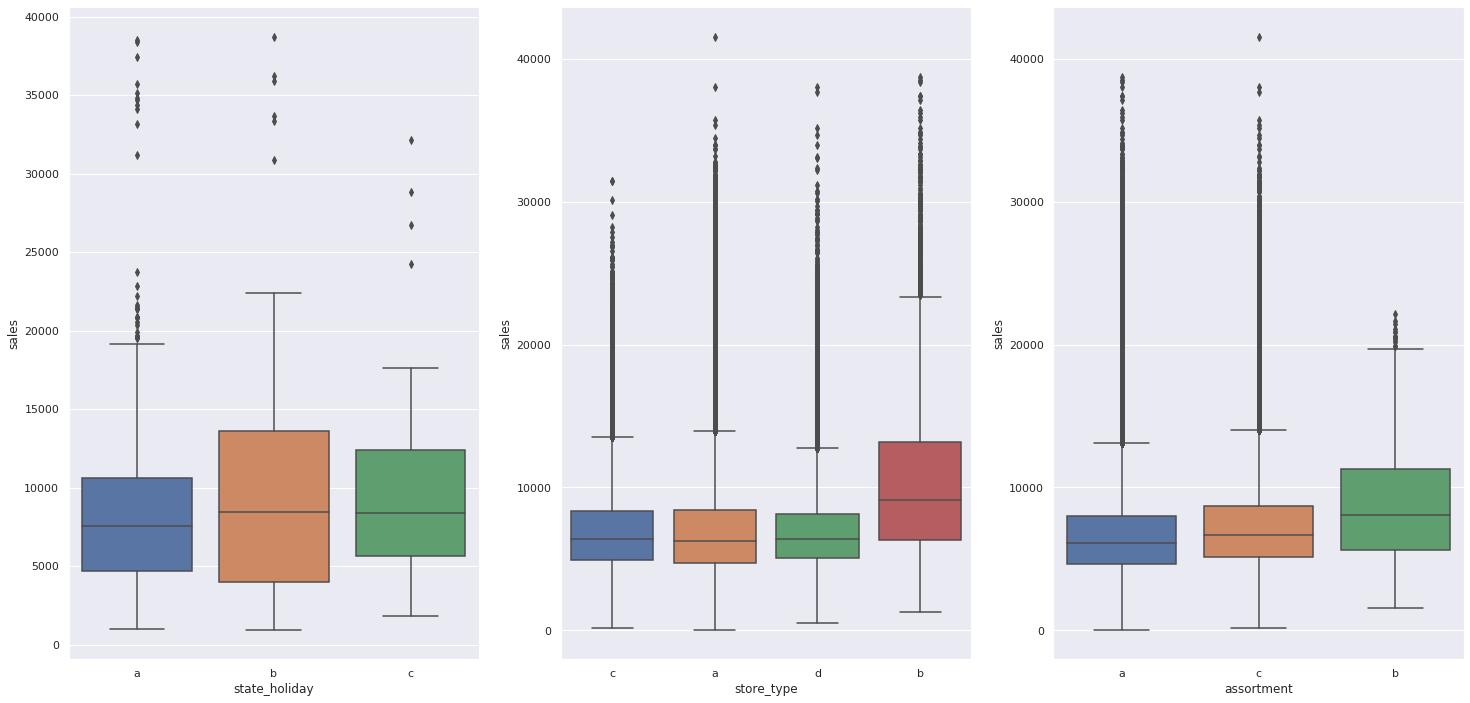

In [19]:
## Visualização da distribuição com boxplot

aux = df1[df1['sales'] > 0] #filtering data

#state_holiday
plt.subplot(1,3,1)
aux1 = aux[aux['state_holiday'] != '0']#removing regular days
sns.boxplot(x='state_holiday', y='sales', data=aux1)

#store_type
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

#assortment
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

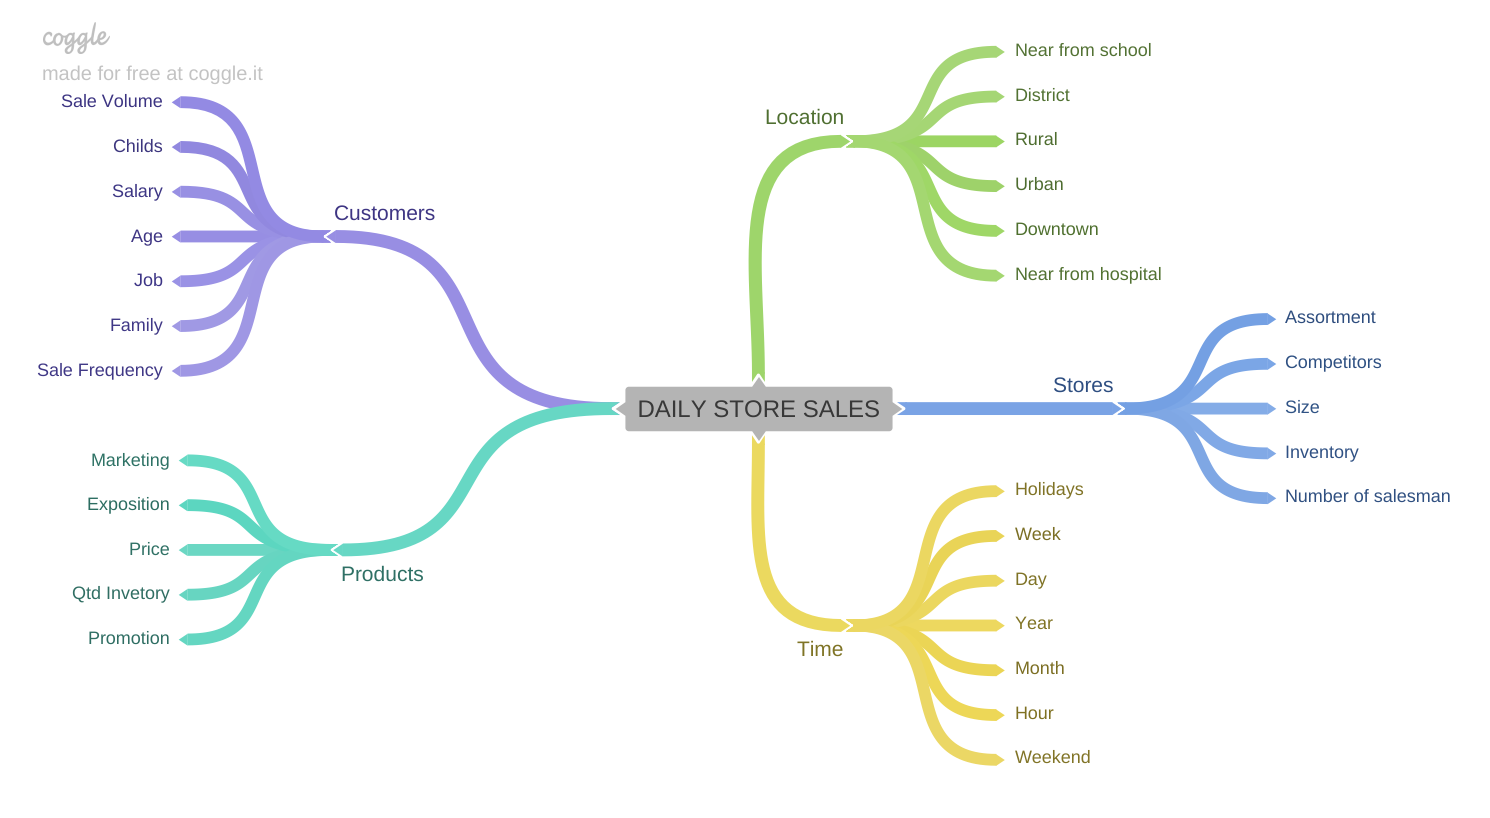

In [21]:
Image('../img/MindMapHypothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Store Hypoteshis

 **1.** Lojas com número maior de funcionários deveriam vender mais.
 
 **2.** Lojas com maior capacidade de estoque deveriam vender mais.
 
 **3.** Lojas com maior porte deveriam vender mais.
 
 **4.** Lojas com maior sortimentos deveriam vender mais.
 
 **5.** Lojas com competidores mais próximos deveriam vender menos.
 
 **6.** Lojas com competidores à mais tempo deveriam vendem mais.
 

### 2.2.2 Product Hypoteshis

 **1.** Lojas que investem mais em Marketing deveriam vender mais.
 
 **2.** Lojas com maior exposição de produto deveriam vender mais.
 
 **3.** Lojas com produtos com preço menor deveriam vender mais.
 
 **5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
 
 **6.** Lojas com promoções ativas por mais tempo deveriam vender mais.
 
 **7.** Lojas com mais dias de promoção deveriam vender mais.
 
 **8.** Lojas com mais promoções consecutivas deveriam vender mais.
 

### 2.2.3 Time Hypoteshis

 **1.** Lojas abertas durante o feriado de Natal deveriam vender mais.
 
 **2.** Lojas deveriam vender mais ao longo dos anos.
 
 **3.** Lojas deveriam vender mais no segundo semestre do ano.
 
 **4.** Lojas deveriam vender mais depois do dia 10 de cada mês.
 
 **5.** Lojas deveriam vender menos aos finais de semana.
 
 **6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Final list of Hypothesis

 **1.** Lojas com maior sortimentos deveriam vender mais.

 **2.** Lojas com competidores mais próximos deveriam vender menos.

 **3.** Lojas com competidores à mais tempo deveriam vendem mais.

 **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
 
 **5.** Lojas com mais dias de promoção deveriam vender mais.
 
 **6.** Lojas com mais promoções consecutivas deveriam vender mais.

 **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
 
 **8.** Lojas deveriam vender mais ao longo dos anos.
 
 **9.** Lojas deveriam vender mais no segundo semestre do ano.
 
 **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
 
 **11.** Lojas deveriam vender menos aos finais de semana.
 
 **12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2.apply(lambda x: datetime.datetime.strptime( x['promo_since'] + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7), axis=1 )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
#a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTERING OF VARIABLES

In [24]:
df3 = df2.copy()

## 3.1. Filtering of rows

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering of columns

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. DATA EXPLORATORY ANALYSIS

In [27]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

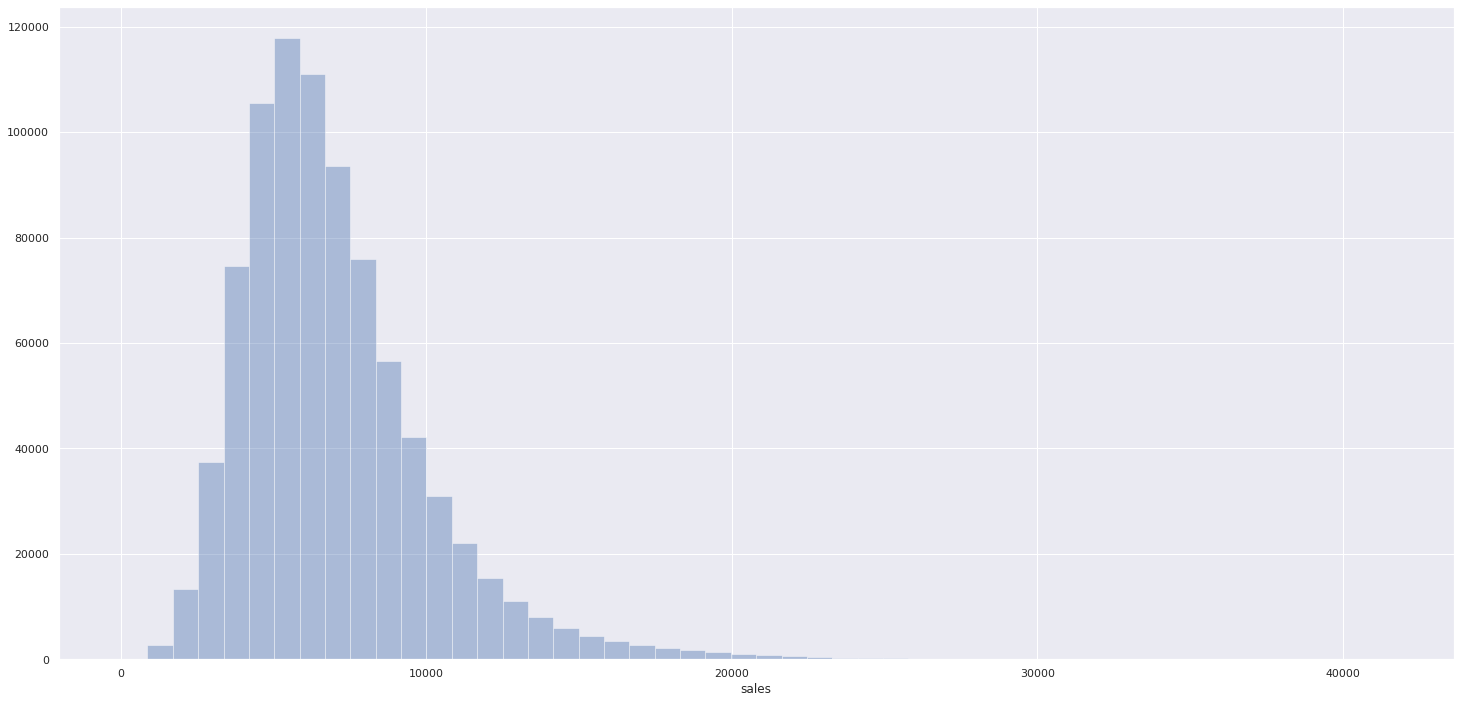

In [28]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

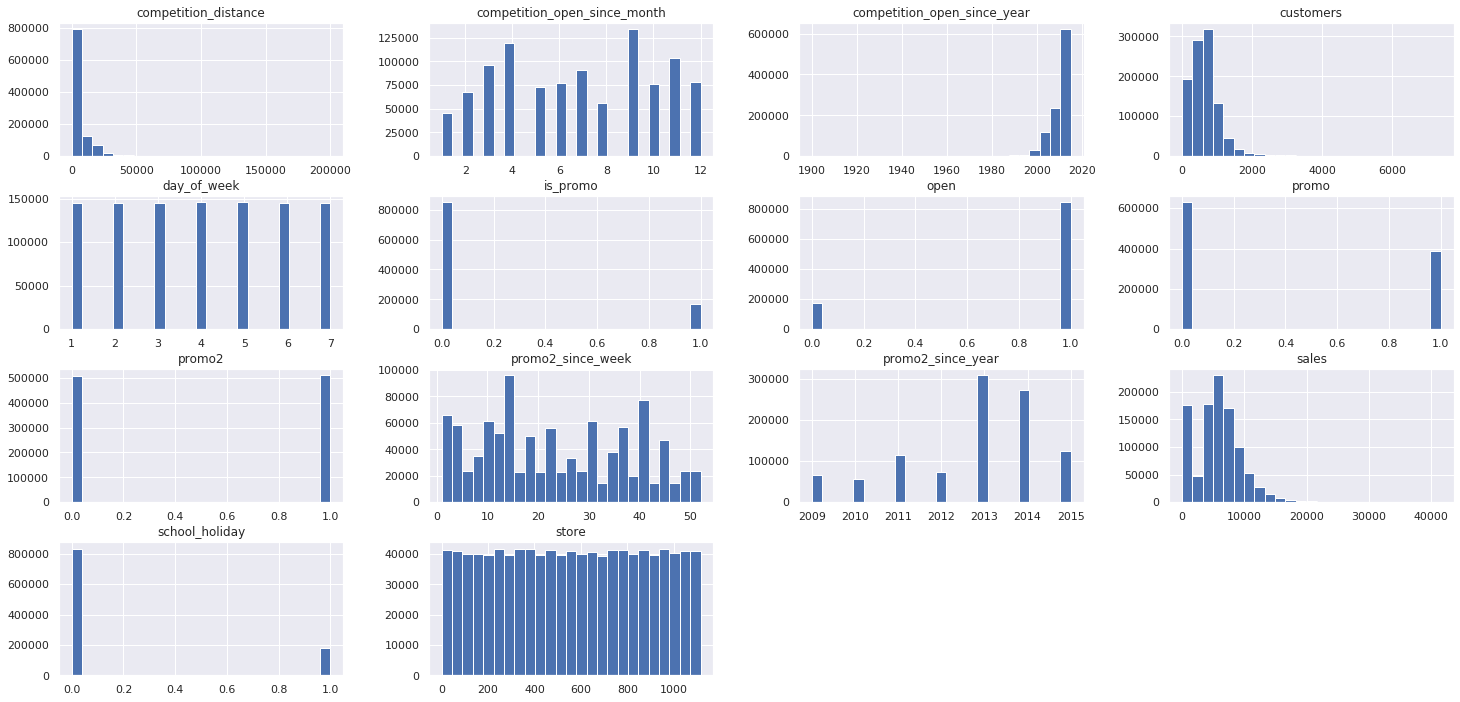

In [29]:
num_attributes.hist(bins= 25);

### 4.1.3. Categorical Variable

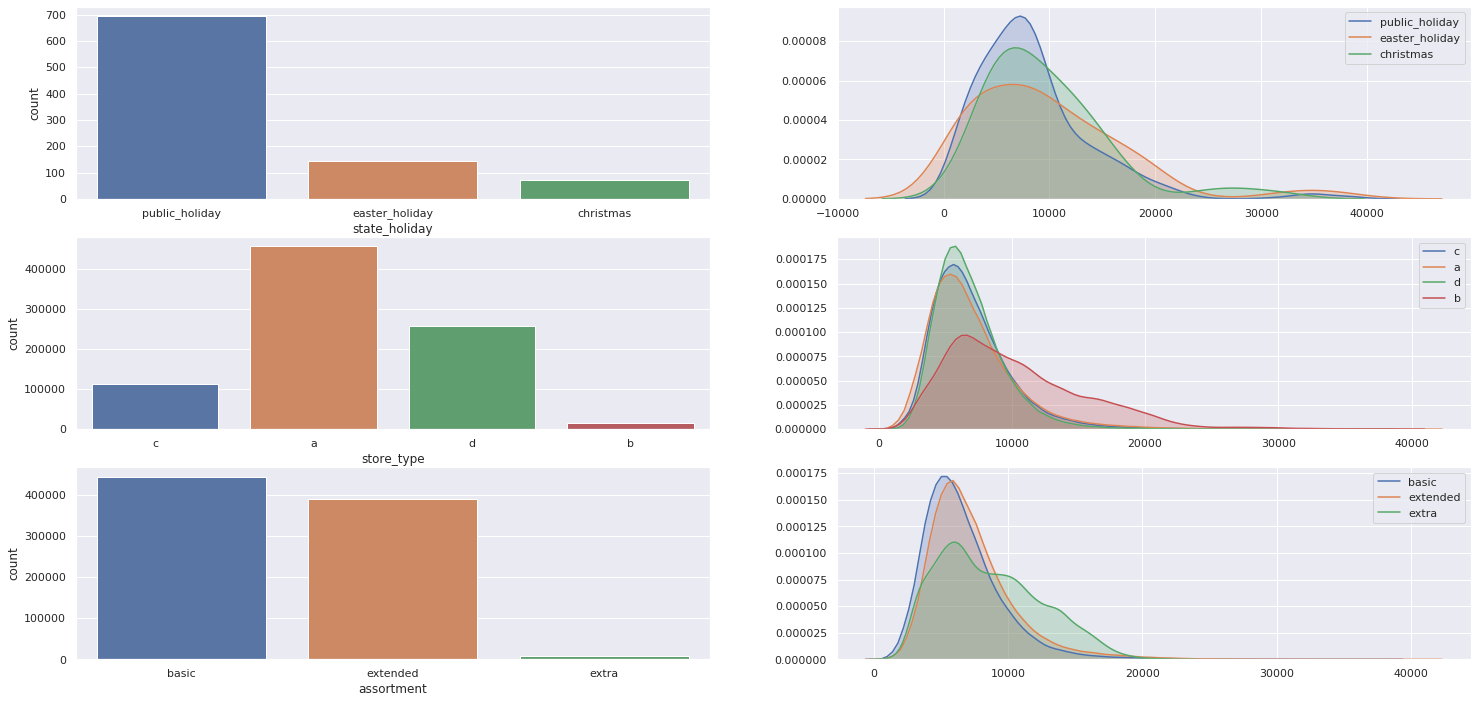

In [30]:
#state_holiday
plt.subplot(3,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(aux['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade=True)

## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA**. Lojas com MAIOR SORTIMENTO vendem MENOS.

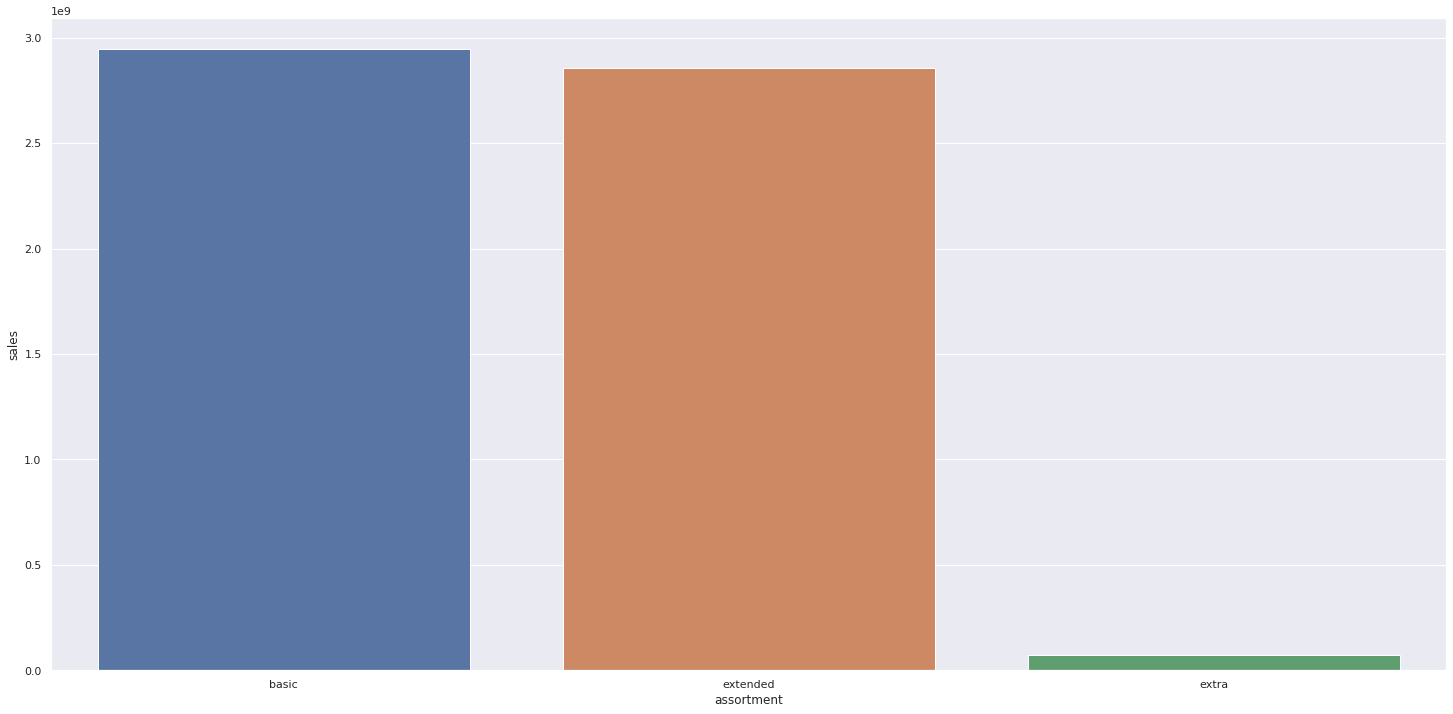

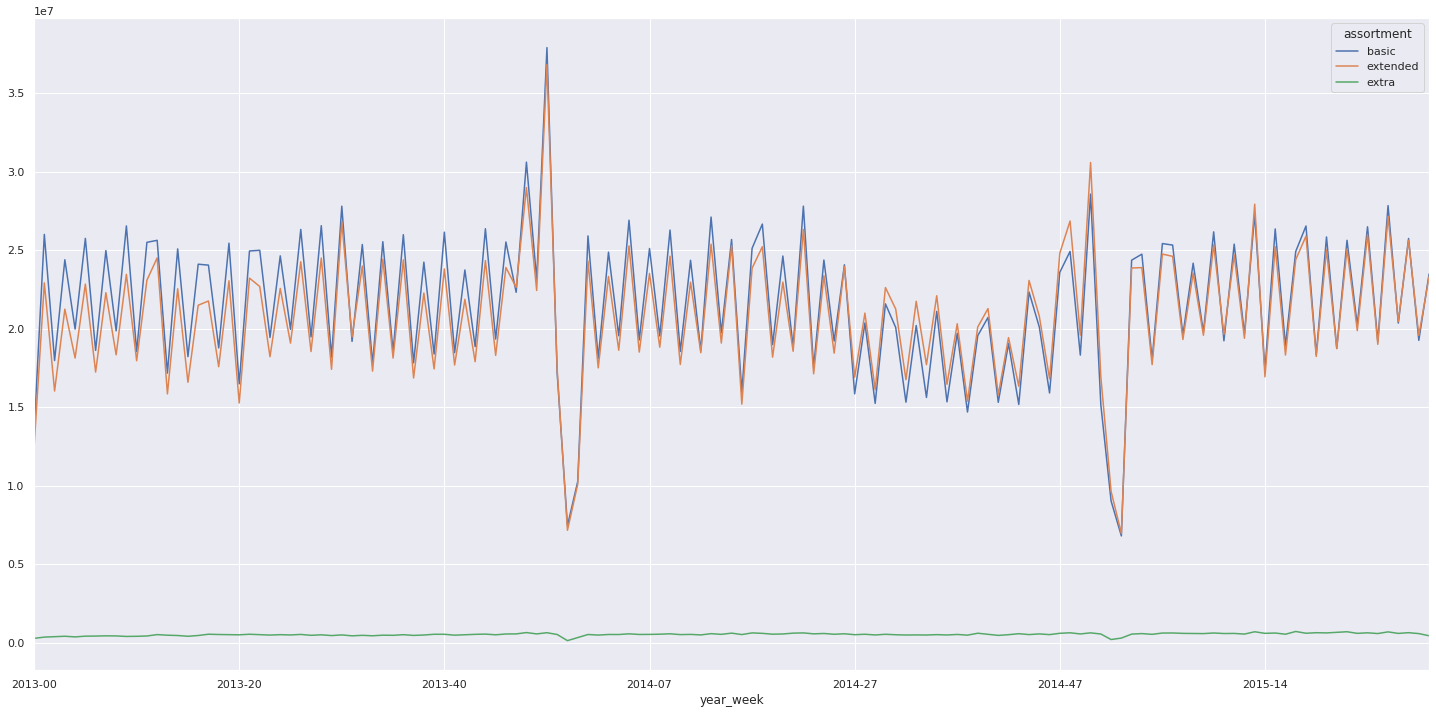

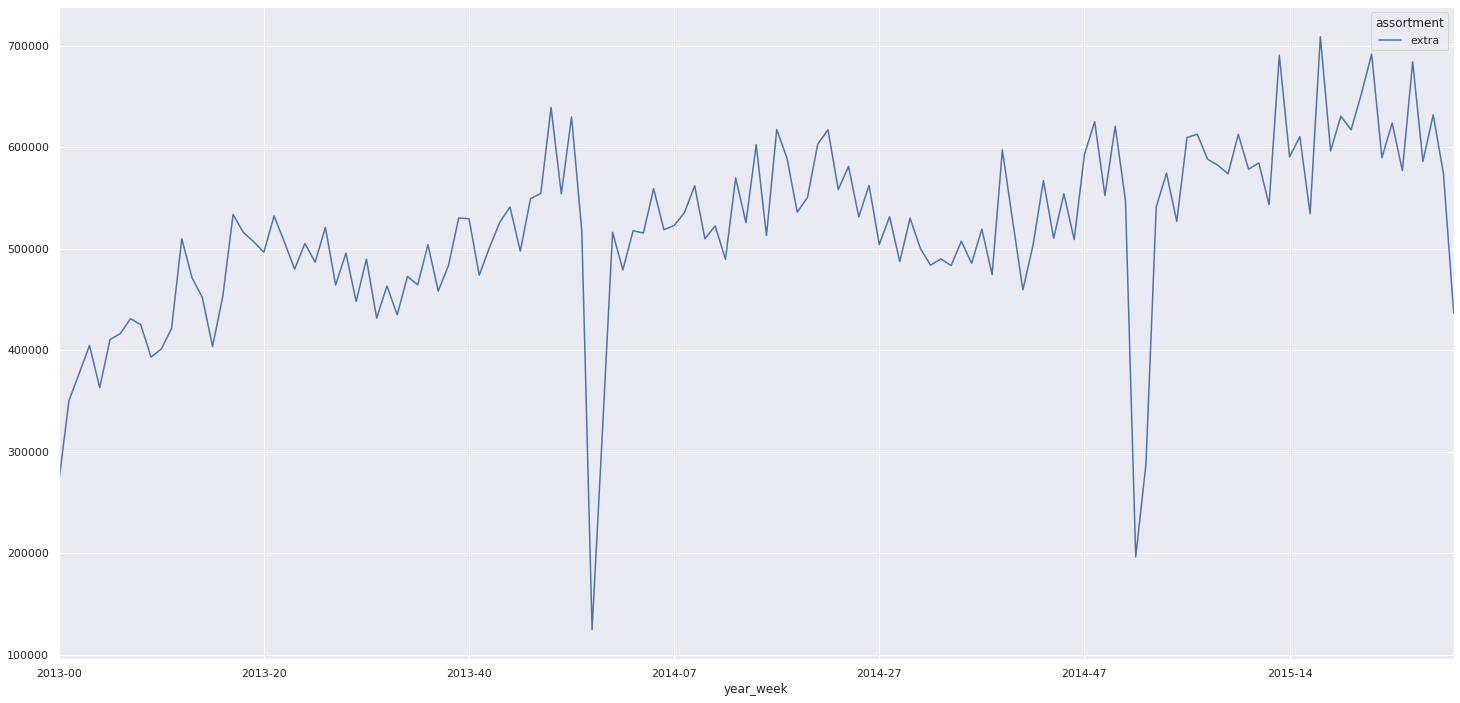

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA**. Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

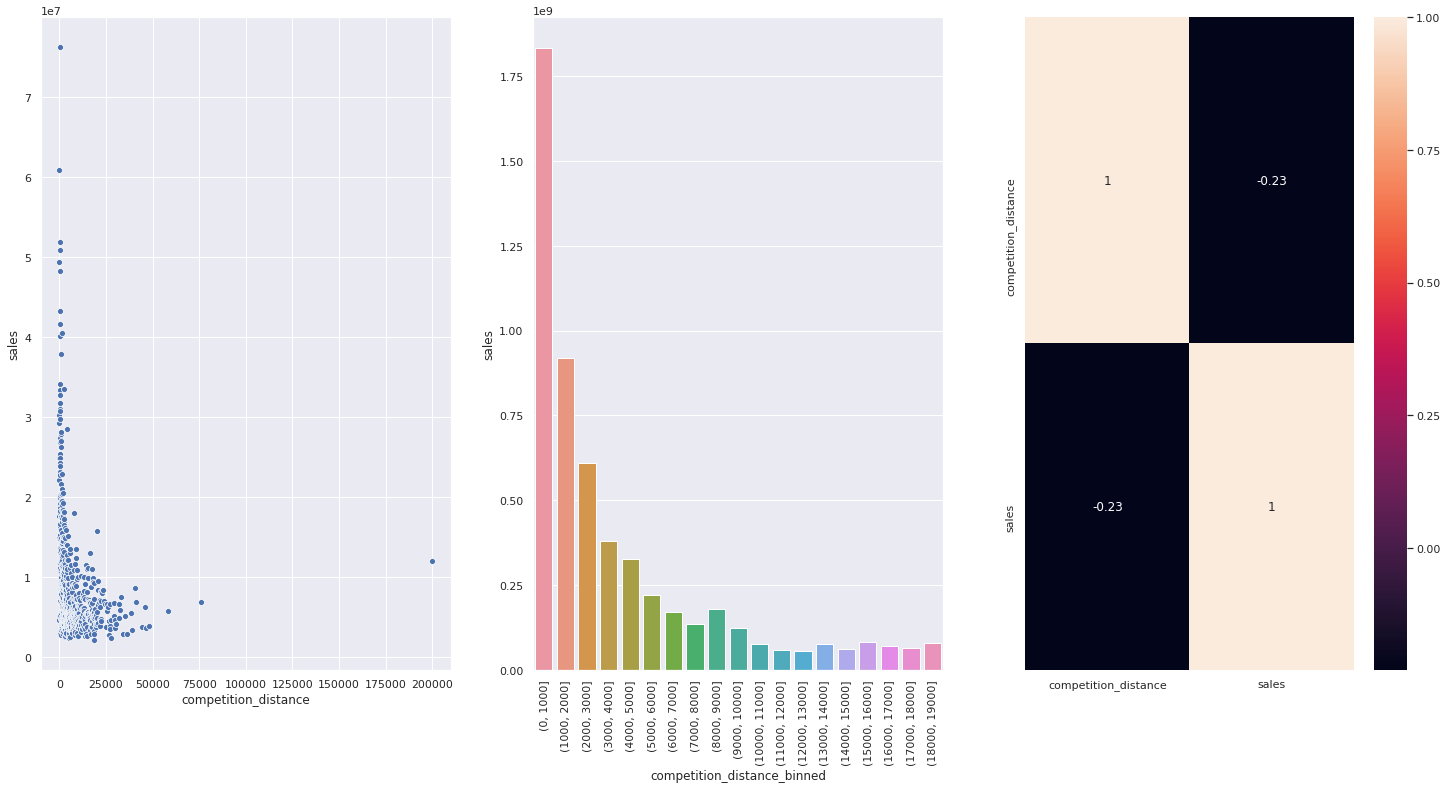

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA**. Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

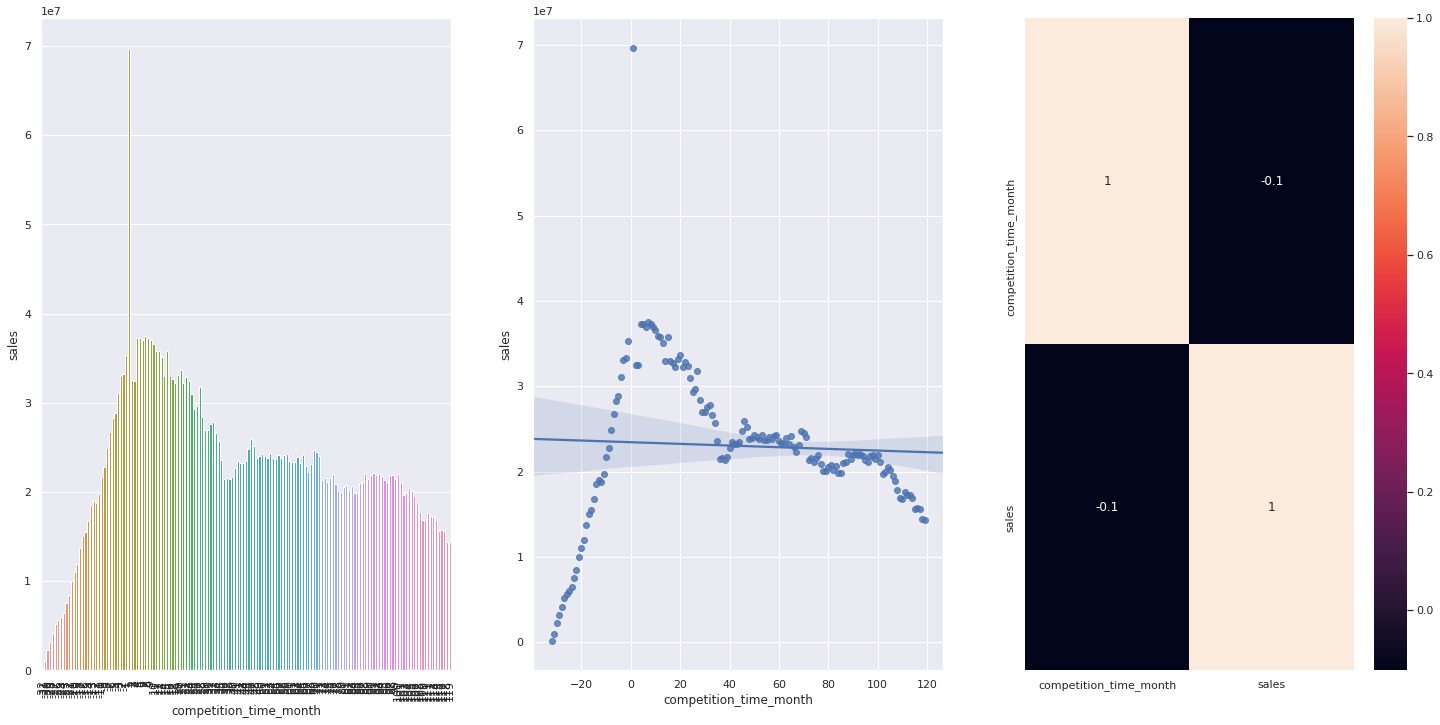

In [33]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month']!= 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo periodo de promoção.

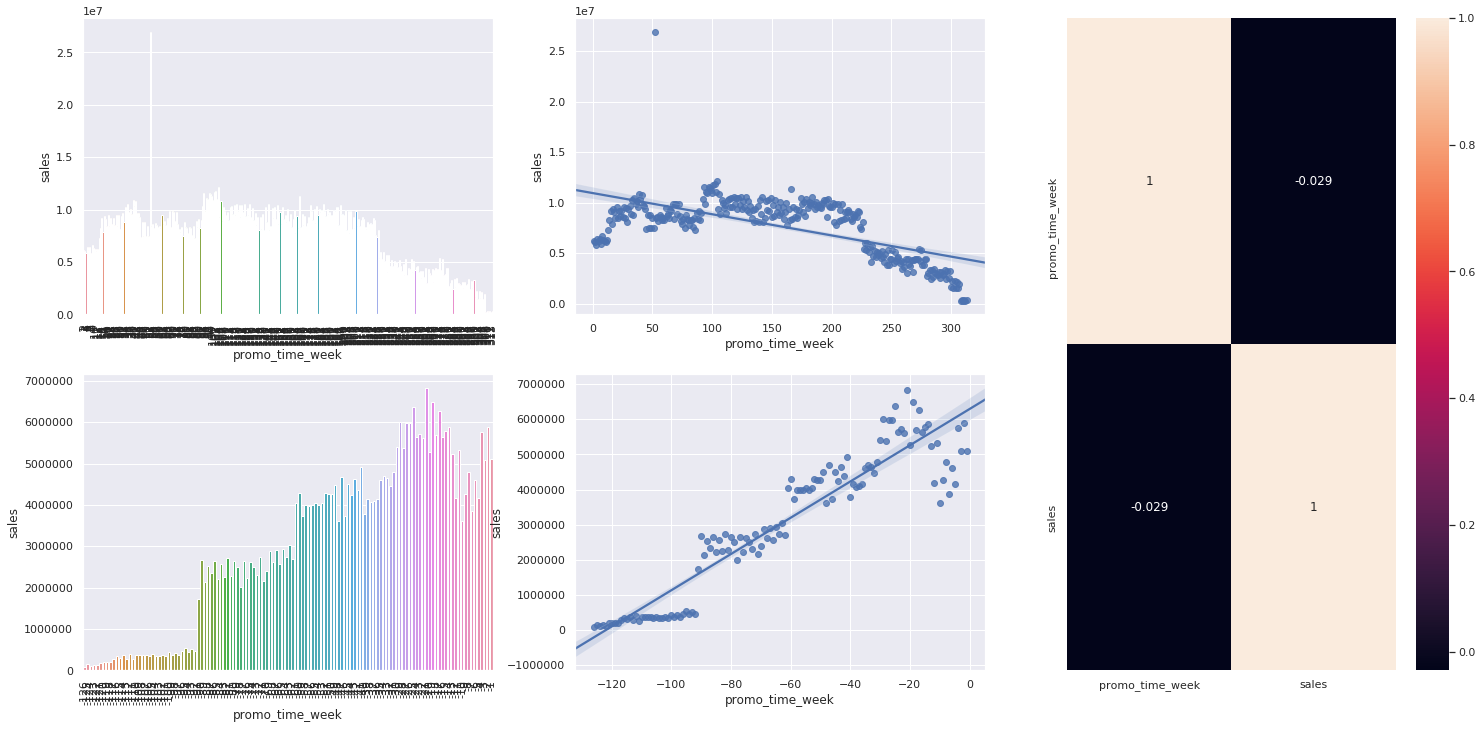

In [34]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo tradicional
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS PROMOÇOES consecutivas vendem MENOS.

In [35]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


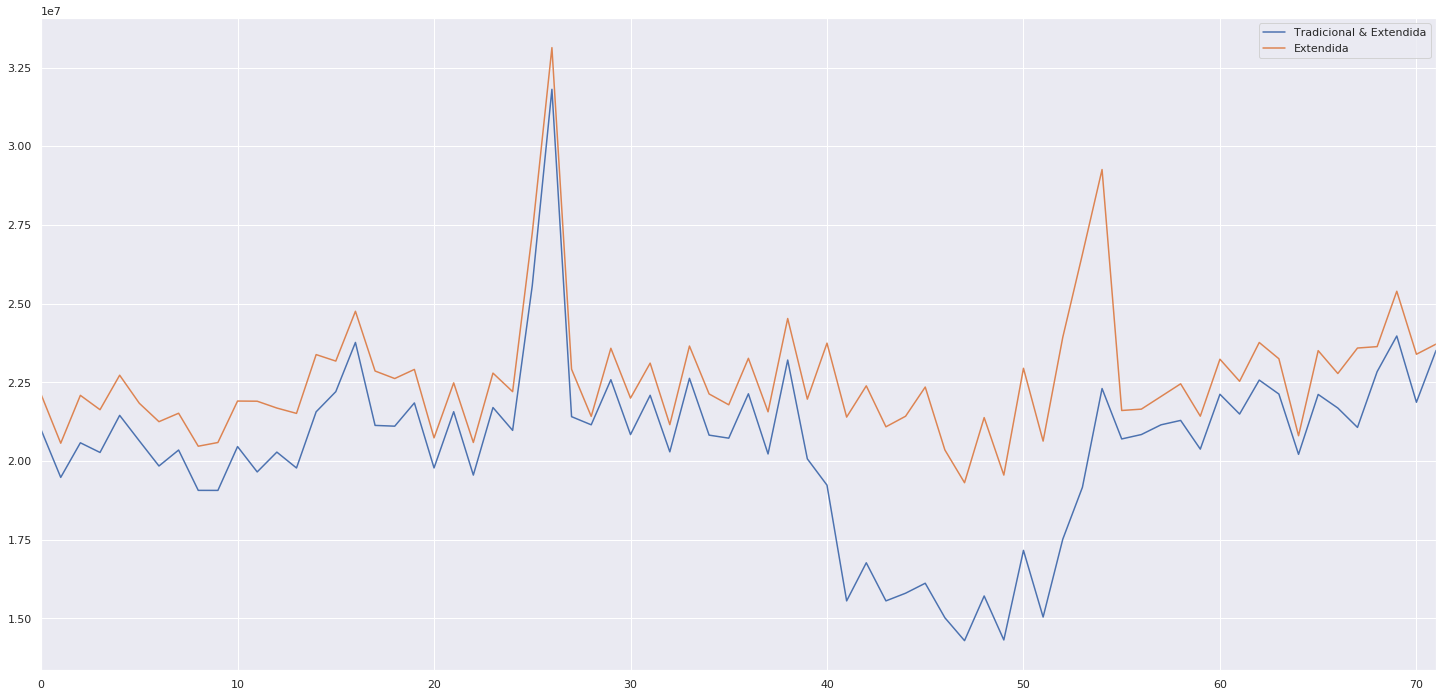

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** Lojas abertas durante o feriado do natal vendem MENOS.

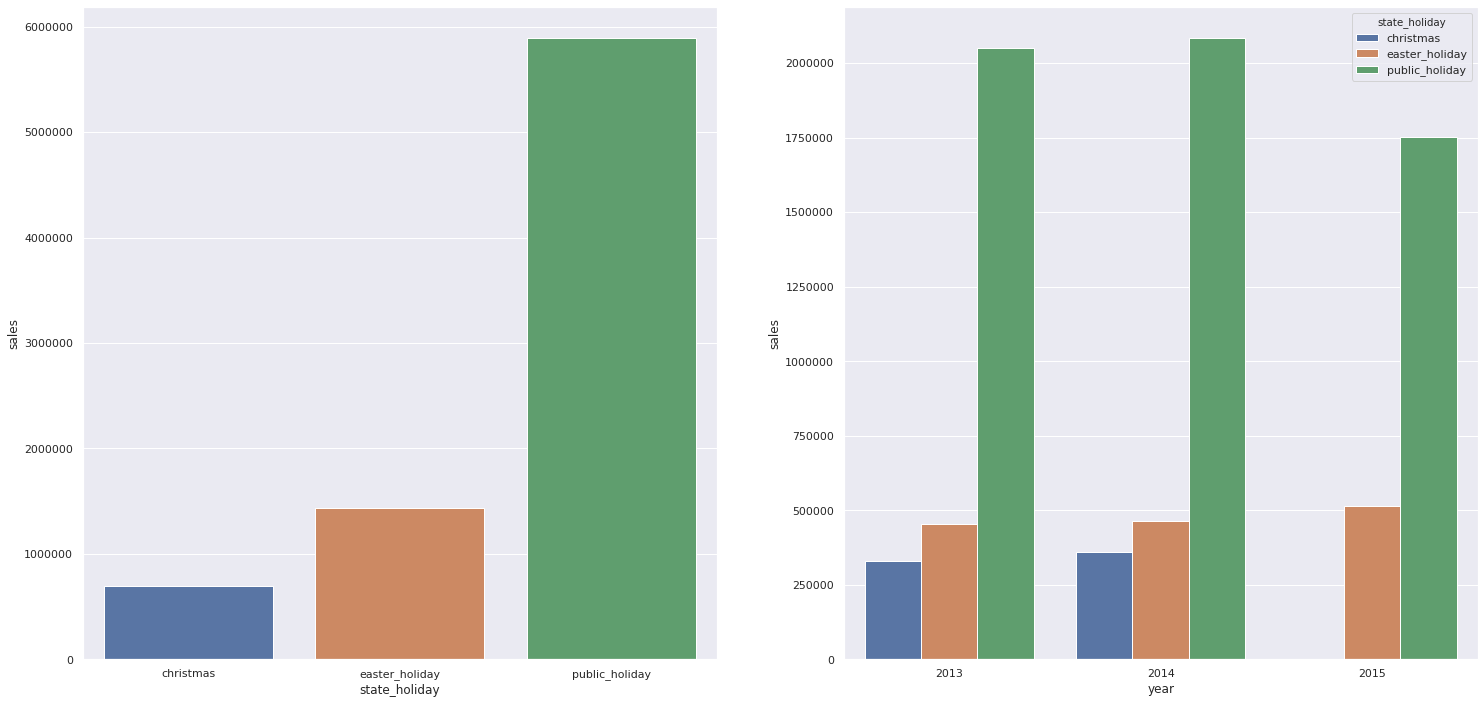

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data= aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data= aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos ANOS.

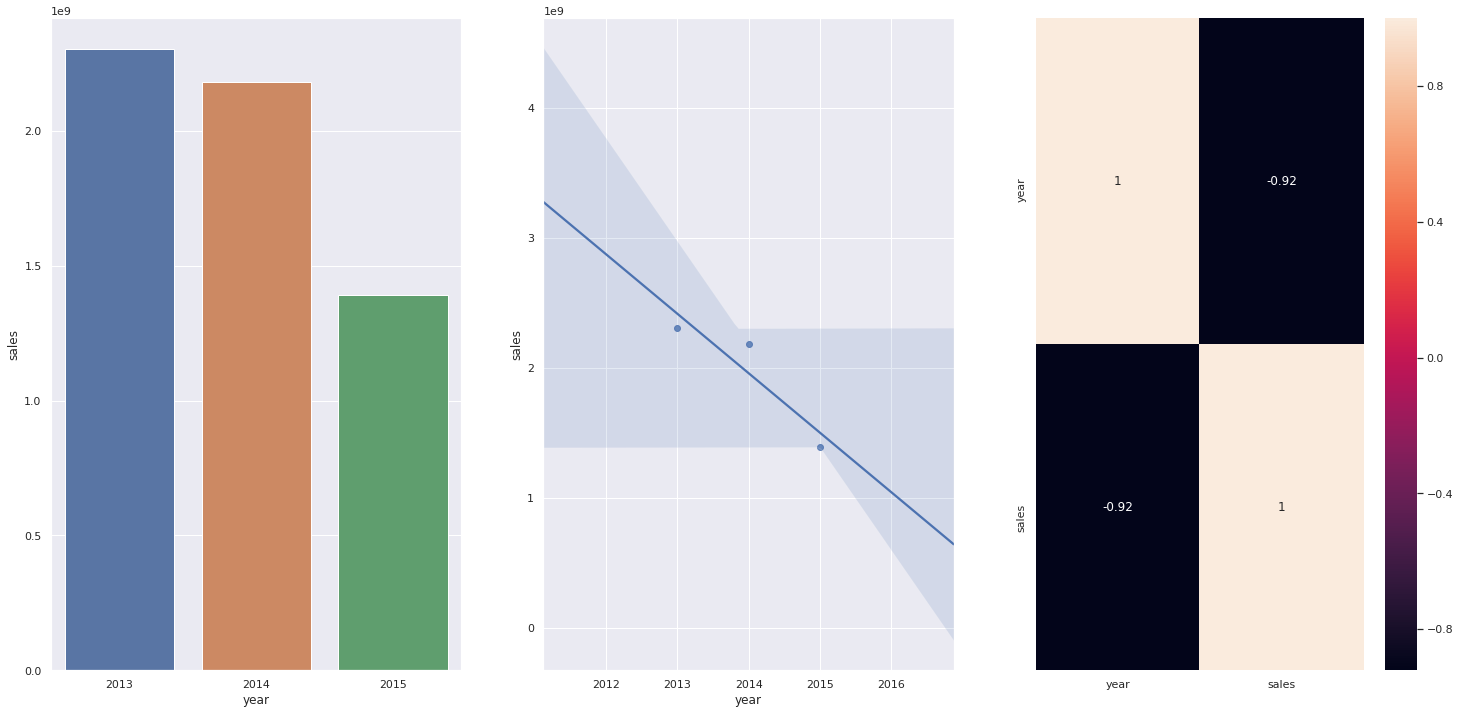

In [38]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano.

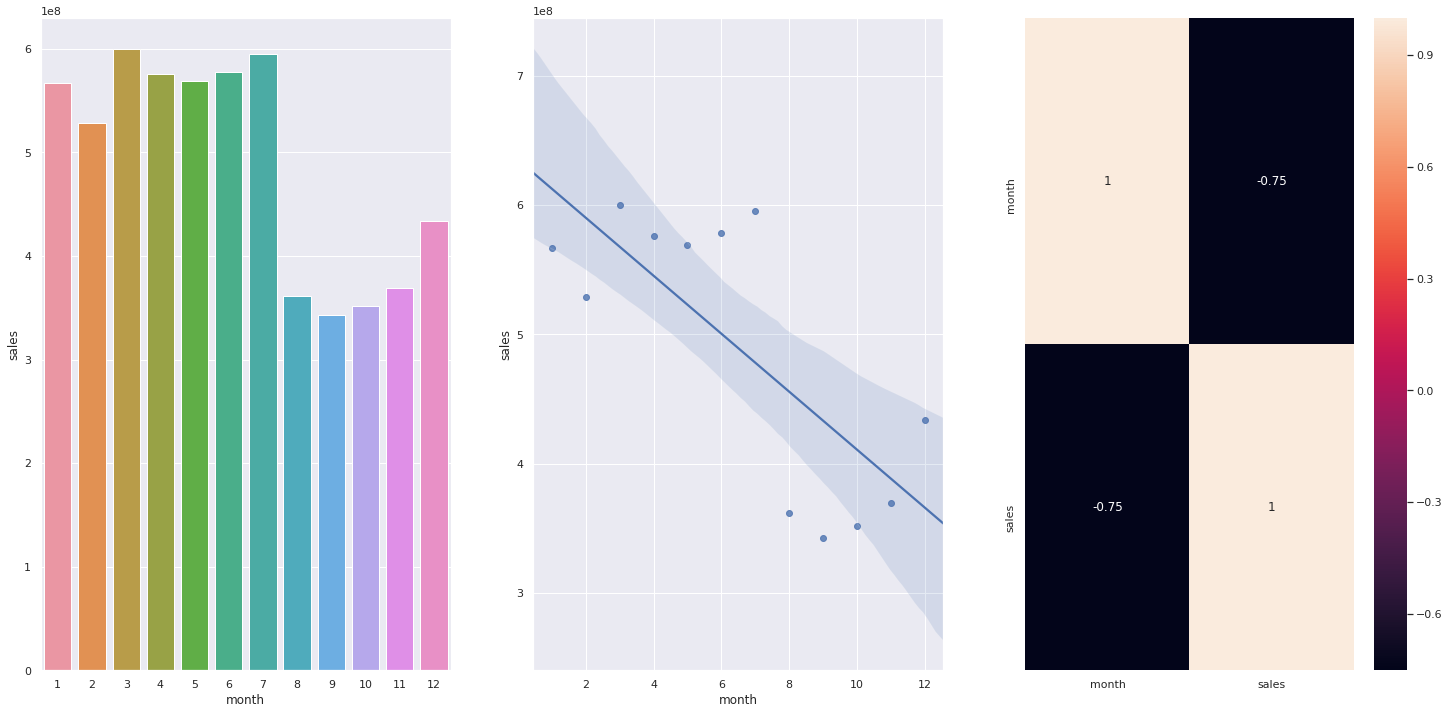

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês.

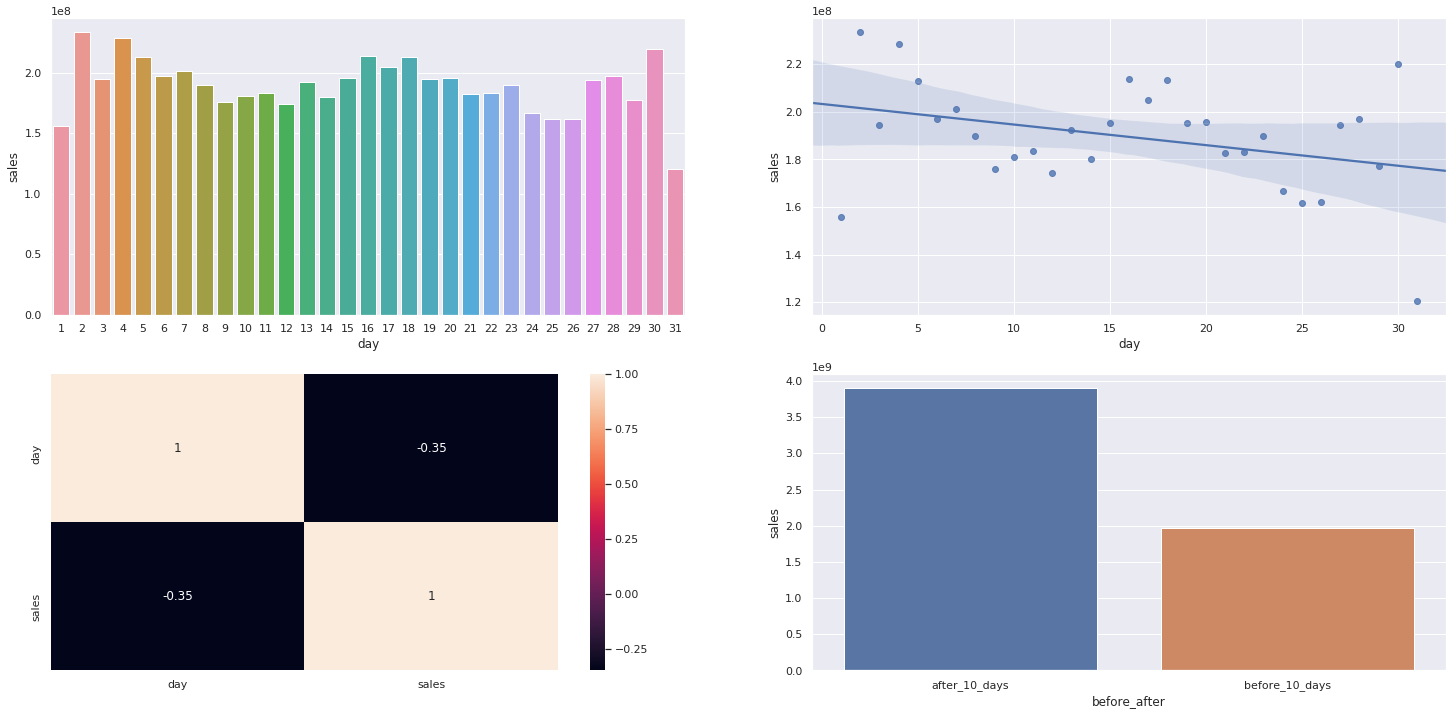

In [40]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS nos finais de semana.

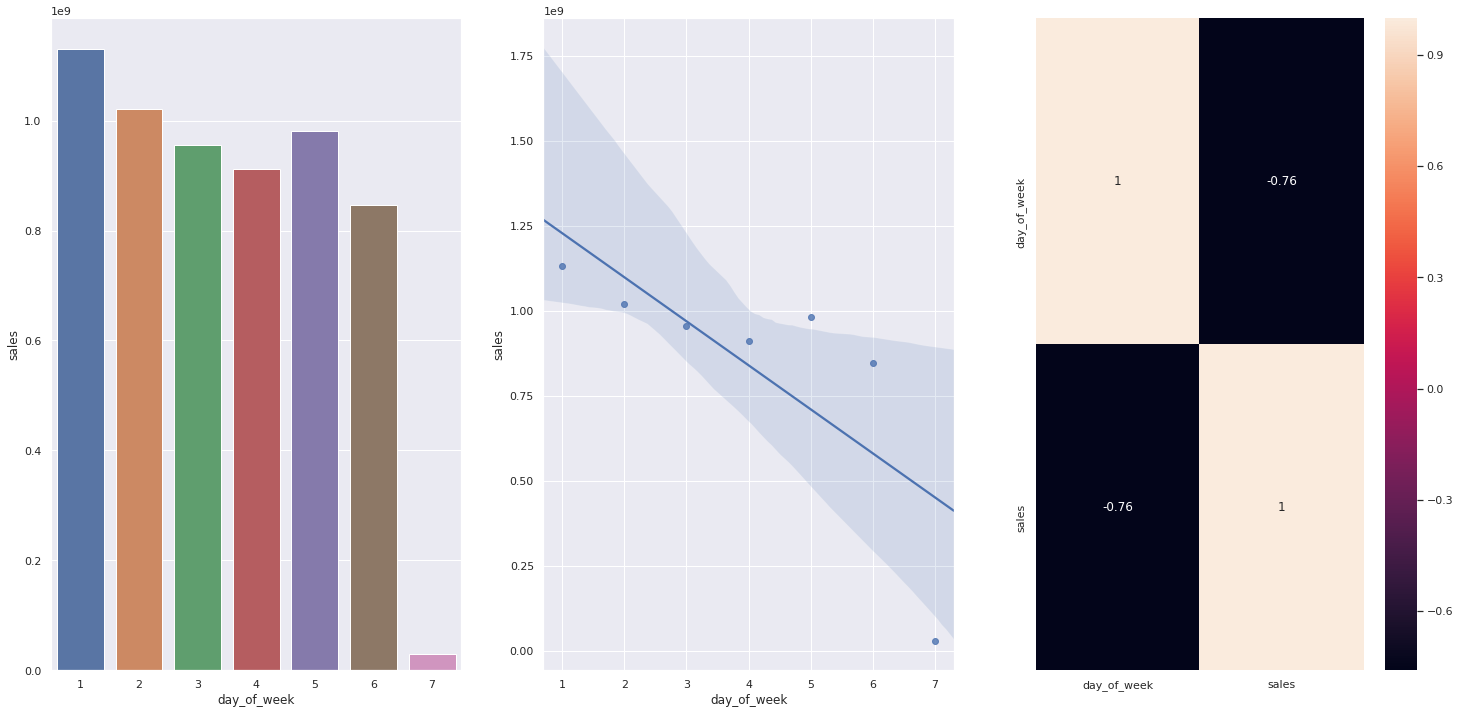

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto os meses de Julho e Agosto

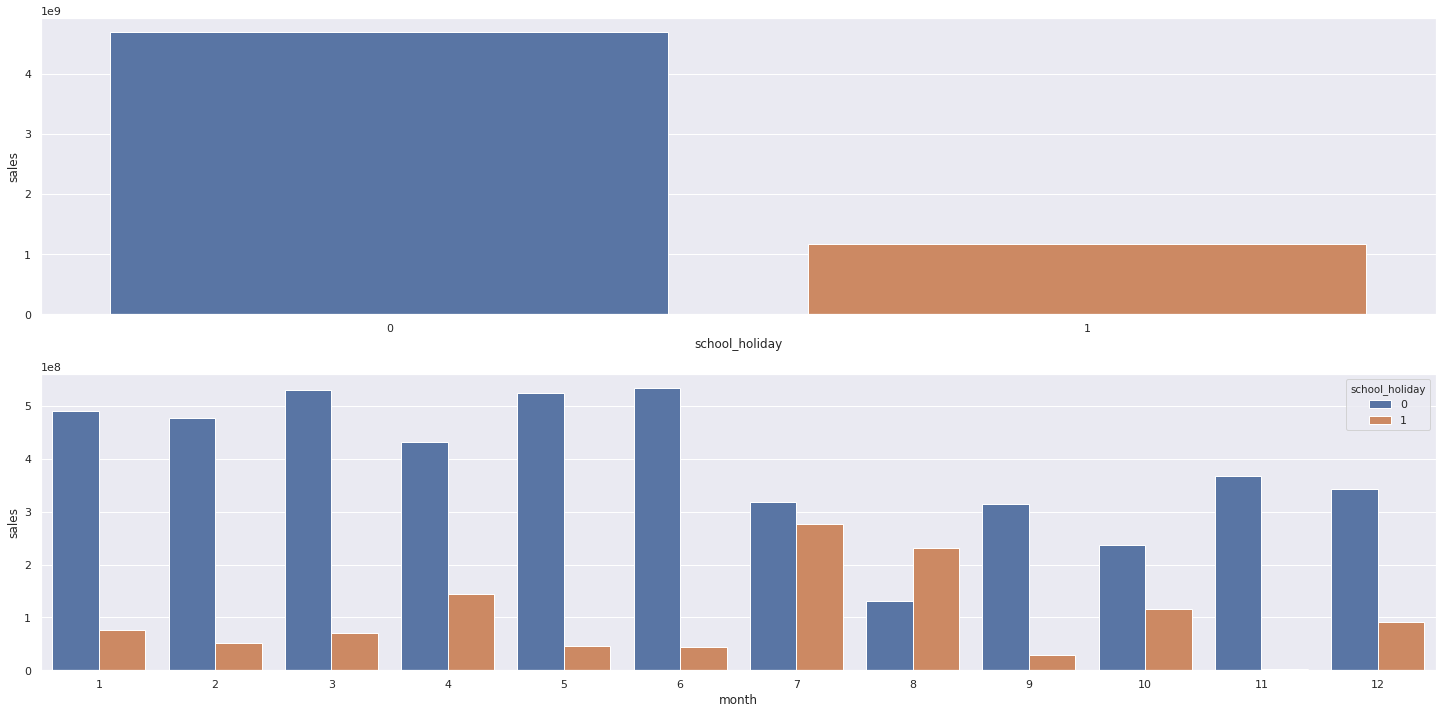

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data= aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', hue='school_holiday', y='sales', data= aux2);

### 4.2.1. Resumo das Hipóteses

In [43]:
from tabulate import tabulate

In [44]:
tab= [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa']
]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

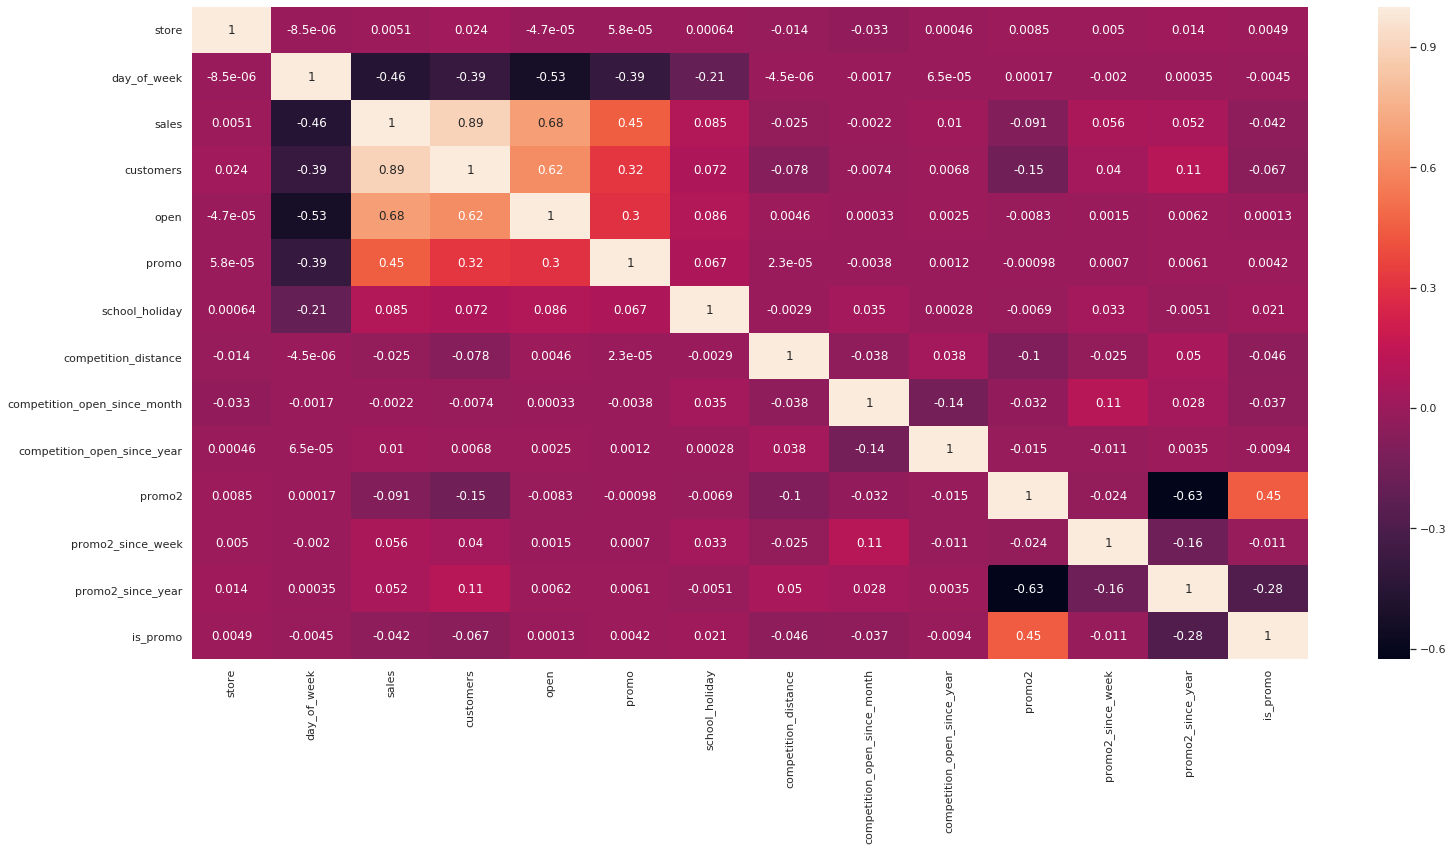

In [45]:
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot= True);

### 4.3.1. Categorical Attributes

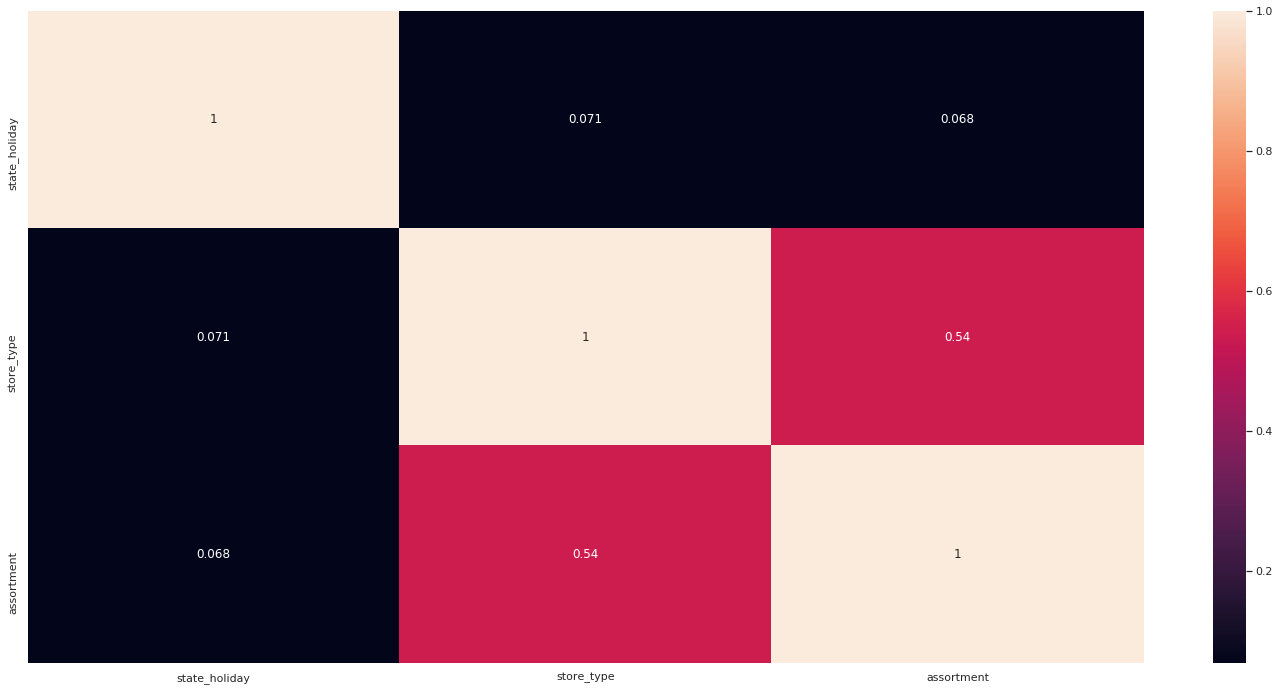

In [46]:
# Only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [47]:
df5 = df4.copy()

## 5.1. Rescaling

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('../parameter/year_scaler.pkl', 'wb'))

## 5.2. Transformation

### 5.2.1. Encoding

In [49]:
# state_holiday - One Hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))


# assortment - Ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.2.2. Response Variable Transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

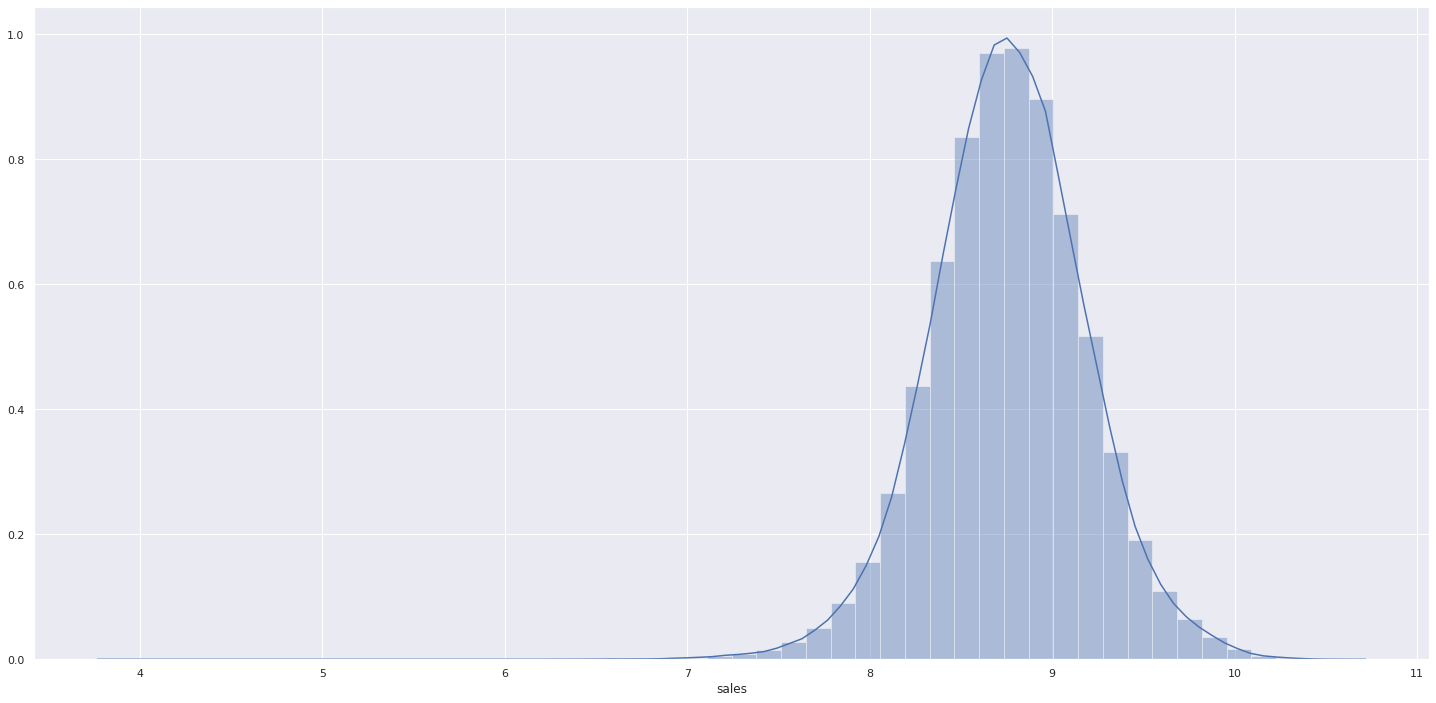

In [51]:
sns.distplot(df5['sales']);

### 5.2.3. Nature Transformation

In [52]:
# day of week
df5['day_of_week_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2* np.pi/7 )))
df5['day_of_week_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2* np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2* np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2* np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2* np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2* np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2* np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2* np.pi/52 )))

In [53]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

# 6.0. PASSO 06 - FEATURE SELECTION

In [5]:
df6 = pd.read_csv('data/df5.csv', low_memory=False).drop('Unnamed: 0', axis=1)

#date
df6['date'] = pd.to_datetime(df6['date'])

#competition_since                          datetime64[ns]
df6['competition_since'] = pd.to_datetime(df6['competition_since'])


#promo_since                                datetime64[ns]
df6['promo_since'] = pd.to_datetime(df6['promo_since'])

#state_holiday_christmas                    uint8
df6['state_holiday_christmas'] = df6['state_holiday_christmas'].astype('uint8')
#state_holiday_easter_holiday               uint8
df6['state_holiday_easter_holiday'] = df6['state_holiday_easter_holiday'].astype('uint8')
#state_holiday_public_holiday               uint8
df6['state_holiday_public_holiday'] = df6['state_holiday_public_holiday'].astype('uint8')
#state_holiday_regular_day                  uint8
df6['state_holiday_regular_day'] = df6['state_holiday_regular_day'].astype('uint8')

## 6.1. Split dataframe into training and test dataset

In [8]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [9]:
# train dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']
print('Max Train dataset: {}'.format(X_train['date'].max()))
print('Min Train dataset: {}'.format(X_train['date'].min()))

print('\nMax Test dataset: {}'.format(X_test['date'].max()))
print('Min Test dataset: {}'.format(X_test['date'].min()))

Max Train dataset: 2015-06-18 00:00:00
Min Train dataset: 2013-01-01 00:00:00

Max Test dataset: 2015-07-31 00:00:00
Min Test dataset: 2015-06-19 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [6]:
## best features
#cols_selected = boruta.support().tolist()
#
#X_train_fs = X_train.drop(['date', 'sales'])
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected]
#
## not selected boruta
#cols_not_selected_boruta = np.setdiff1d(X_train_fs.colmns, cols_selected_boruta.columns)

## 6.3. Manual Feature Selection - after Boruta

In [10]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [11]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Avarage Model

In [ ]:
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()
#
## prediction
#aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
#
#aux1 = pd.merge(aux1, aux2, how='left', on='store')
#yhat_baseline = aux1['predictions']
#
## performance
#baseline_result = ml_error('Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline))
#baseline_result

## 7.2. Linear Regression Model

In [ ]:
## model
#lr = LinearRegression().fit(x_train, y_train)
#
## prediction
#yhat_lr = lr.predict(x_test)
#
## performance
#lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
#lr_result_cv

## 7.3. Linear Regression Regularized Model - LASSO

In [ ]:
# model
#lrr = Lasso(alpha=0.01).fit(x_train, y_train)
#
## prediction
#yhat_lrr = lrr.predict(x_test)
#
## performance
#lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
#lrr_result

### 7.3.1. Lasso - Cross Validation

In [ ]:
#lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
#lrr_result_cv

## 7.4. Random Forest Regressor

In [ ]:
## model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=True).fit(x_train, y_train)
#
## prediction
#yhat_rf = rf.predict(x_test)
#
## performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
## model
#model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=100,
#                              eta= 0.01,
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)
#
## prediction
#yhat_xgb = model_xgb.predict(x_test)
#
## performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

## 7.6. Compare Mode'l Performance

### 7.6.1. Single Performance

In [7]:
#modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modeling_result.sort_values('RMSE')

### 7.6.2. Real Performance - Cross Validation

In [ ]:
#modeling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modeling_result.sort_values('RMSE')

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#    }
#
#MAX_EVAL = 2

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters ramdonly
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)
#
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'],
#                                eta= hp['eta'],
#                                max_depth= hp['max_depth'],
#                                subsample=hp['subsample'],
#                                colsample_bytree=hp['colsample_bytree'],
#                                min_child_weight=hp['min_child_weight'])
#
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor - ' + str(i), model_xgb, verbose= False)
#    final_result = pd.concat([final_result, result])
#
#final_result

## 8.2.Final Model

In [ ]:
#param_tuned = {
#    'n_estimators': 3000,
#    'eta': 0.03,
#    'max_depth': 5,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'min_child_weight': 3 
#    }

In [ ]:
## model
#model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                    n_estimators=param_tuned['n_estimators'],
#                                    eta= param_tuned['eta'],
#                                    max_depth= param_tuned['max_depth'],
#                                    subsample=param_tuned['subsample'],
#                                    colsample_bytree=param_tuned['colsample_bytree'],
#                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
#
##prediction
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
#
## performance
#xgb_result_tuned = ml_error('XGB Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned

In [ ]:
#mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#mpe

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sample(4)

In [ ]:
#Para mostrar que existem mais lojas desafiadoras que outras.
df92.sort_values('MAPE', ascending=False).head()

In [ ]:
#Para mostrar que existem mais lojas desafiadoras que outras no gráfico.
sns.scatterplot(x='store', y='MAPE', data= df92)

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('${:,.2f}'.format)
df93

## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data= df9, label='SALES')
sns.lineplot(x='date', y='predictions', data= df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data= df9)
plt.axhline(1, linestyle='--')


plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

In [ ]:
#Save Trained Model
#pickle.dump( model_xgb_tuned, open('../model/model_rossmann.pkl', 'wb') )